# 6.6 Sourcing & Analyzing Federal Reserve Disposable Personal Income Time-Series Data

## Contents:

### 1. Importing your libraries and data
### 2. Subsetting, wrangling, and cleaning time-series data
### 3. Time series analysis: decomposition
### 4. Testing for stationarity
### 5. Stationarizing the Federal Reserve Economic Data

## 01. Import Libraries and Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'Zixb2Jzb9k4cyDzy1d7a'

In [6]:
# Importing the Federal Reserve Economic Data "Disposable Personal Income" variable.

data = quandl.get('FRED/DSPI')

In [7]:
data.head()

,Value
Date,
1959-01-01,351.5
1959-02-01,352.9
1959-03-01,355.2
1959-04-01,358.2
1959-05-01,360.3


In [8]:
data.shape

(756, 1)

In [9]:
data.columns

Index(['Value'], dtype='object')

In [10]:
type(data)

pandas.core.frame.DataFrame

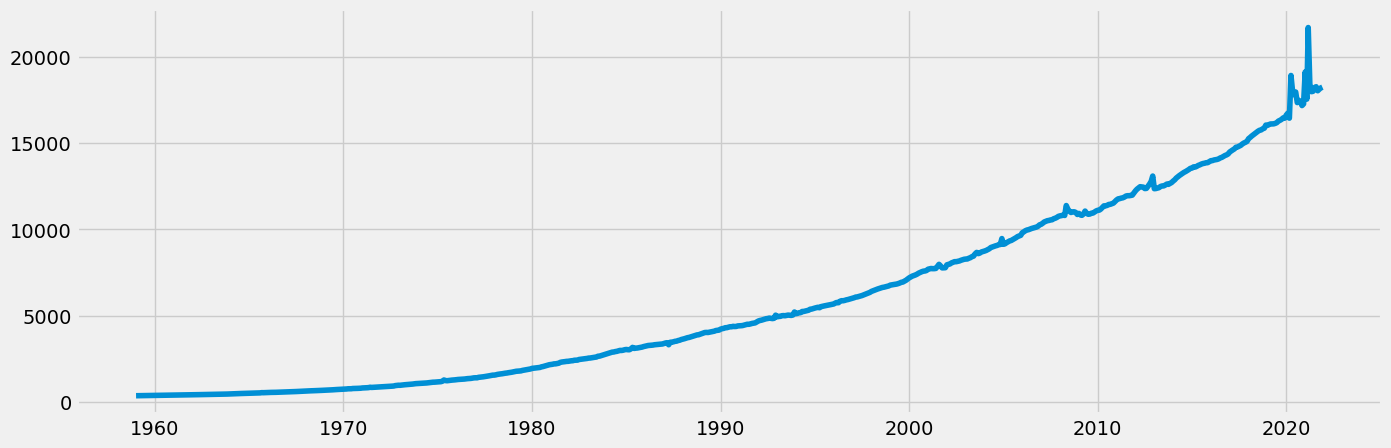

In [11]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

## 02. Subsetting, wrangling, and cleaning time-series data

In [12]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [13]:
data_2.head()

,Date,Value
0,1959-01-01,351.5
1,1959-02-01,352.9
2,1959-03-01,355.2
3,1959-04-01,358.2
4,1959-05-01,360.3


In [63]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2022-11-30')]

In [64]:
data_sub.shape

(504, 2)

In [65]:
data_sub.head()

,Date,Value
252,1980-01-01,1936.3
253,1980-02-01,1946.8
254,1980-03-01,1958.3
255,1980-04-01,1966.3
256,1980-05-01,1974.3


In [66]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,1936.3
1980-02-01,1946.8
1980-03-01,1958.3
1980-04-01,1966.3
1980-05-01,1974.3


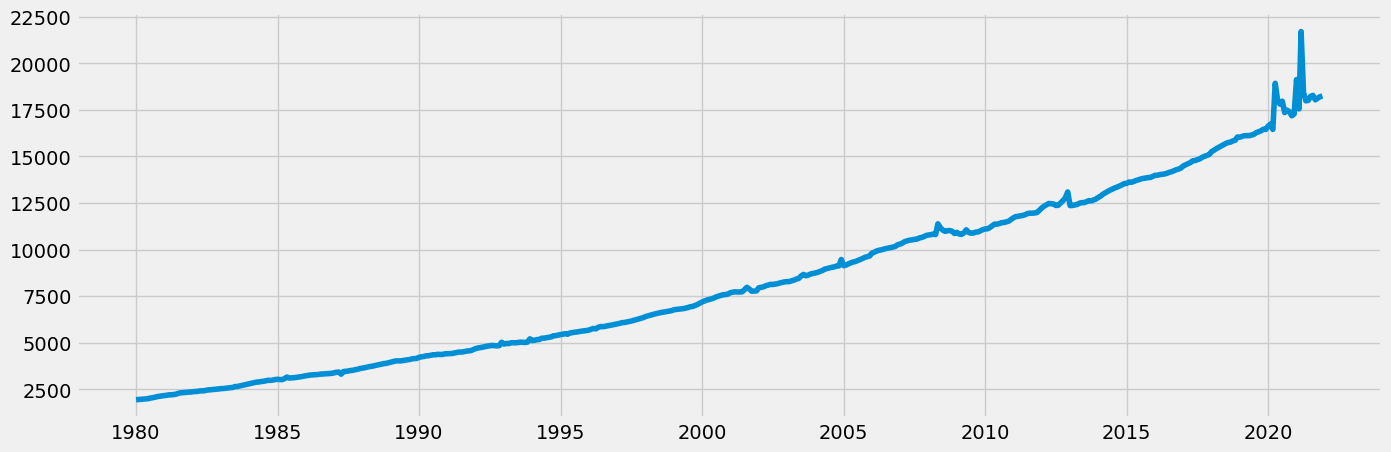

In [67]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [68]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [69]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()


2

In [70]:
data_sub.drop_duplicates(keep=False)

,Value
datetime,
1980-01-01,1936.3
1980-02-01,1946.8
1980-03-01,1958.3
1980-04-01,1966.3
1980-05-01,1974.3
...,...
2021-08-01,18268.7
2021-09-01,18035.1
2021-10-01,18122.8


## 03. Time-series analysis: decomposition

In [71]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [72]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

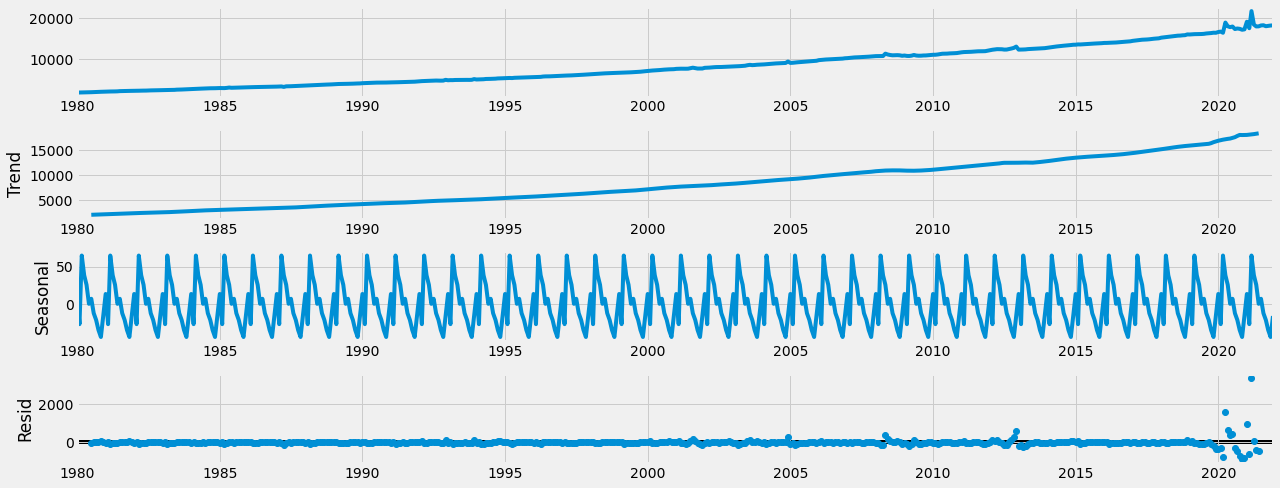

In [73]:
# Plot the separate components

decomposition.plot()
plt.show()

## 04. Testing for stationarity

Null Hypothesis: There is a unit root and data is non stationary 

Alt Hypothesis: There is no unit root and data is stationary

Disprove the null = no unit root = stationary data = can proceed with forecast

In [74]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   2.581470
p-value                          0.999071
Number of Lags Used             17.000000
Number of Observations Used    486.000000
Critical Value (1%)             -3.443877
Critical Value (5%)             -2.867505
Critical Value (10%)            -2.569947
dtype: float64


Using a significance level of 5% the critical value -2.867505 is much smaller than the test statistic of 2.581470, which means we cannot reject the null hypothesis and there is a unit root and the data is as we previously thought from looking at decomposition chart non stationary. 

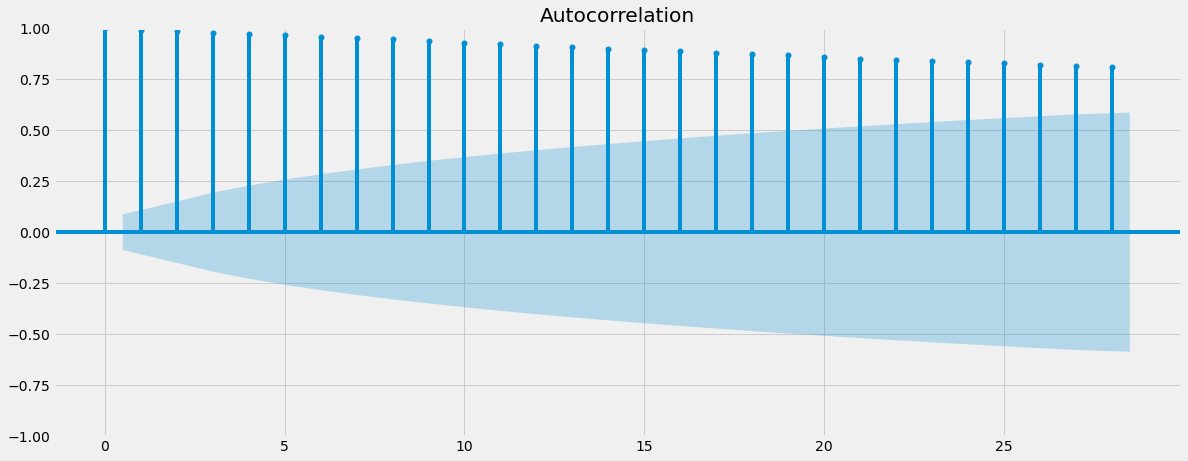

In [75]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means you have lags that are significantly correlated with each other. And when you have many lags beyond this interval, you can deduce that your data is non-stationary. As you can see from the above example, the Federal Reserve time series has quite a few lags correlated with each other. This means there’s a lot of autocorrelated data and the set is likely non-stationary, which supports the result of the Dickey-Fuller test you conducted earlier.

## 05. Stationarizing the Federal Reserve Economic Data

I've proven, basically beyond a doubt, that the data is non-stationary (has a trend), and since we know that we can’t forecast with non-stationary data, I first need to make it stationary. In order to do so, I'll be running through some steps to extract the trend from the data by removing any unnecessary variance.

In [76]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [77]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [78]:
data_diff.head()

,Value
datetime,
1980-02-01,10.5
1980-03-01,11.5
1980-04-01,8.0
1980-05-01,8.0
1980-06-01,16.8


In [79]:
data_diff.columns

Index(['Value'], dtype='object')

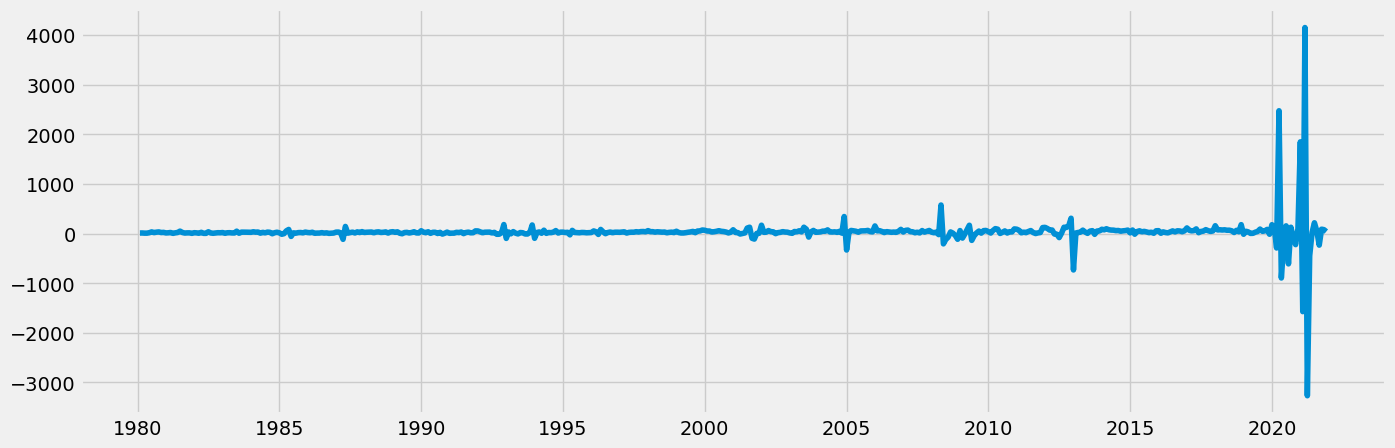

In [80]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [81]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.106424
p-value                          0.000945
Number of Lags Used             16.000000
Number of Observations Used    486.000000
Critical Value (1%)             -3.443877
Critical Value (5%)             -2.867505
Critical Value (10%)            -2.569947
dtype: float64


Success! The test statistic is now smaller than the critical value at both the five and ten percent significance levels. We also have a satisfactory p-value (p<0.05). This means we can reject the null hypothesis and, as a result, consider the series stationary.

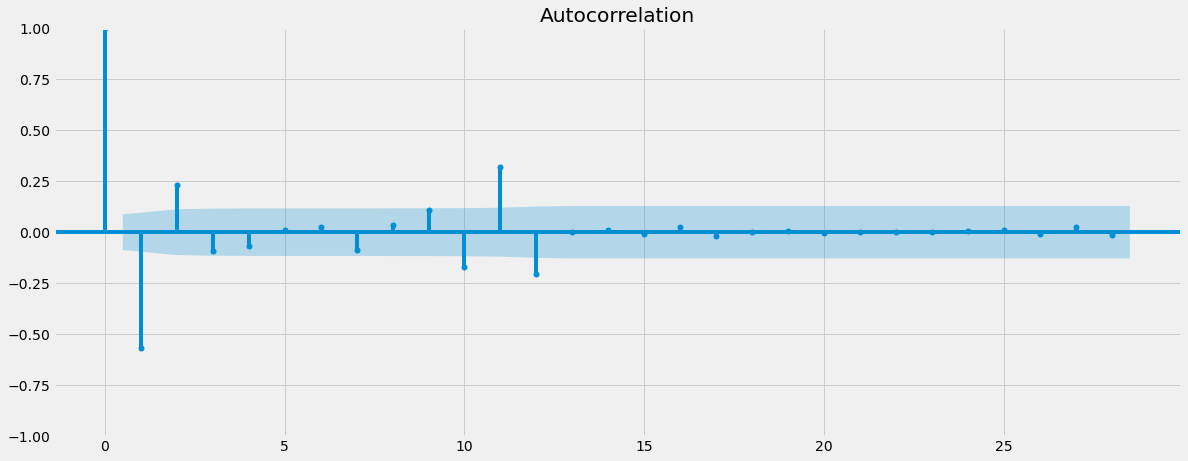

In [82]:
plot_acf(data_diff)
plt.show()

While the autocorrelation plot has improved (there are fewer autocorrelated terms), it’s still not perfect. This means that, despite the Dickey-Fuller test saying that the data is stationary, that stationarity is weak. If we wanted, we could conduct another round of differencing to stationarize it further and reduce the remaining autocorrelated terms, but for the purpose of this example, we will stop here. This is because of the unspoken rule of thumb that we need at least ten significant lags (or ten vertical lines above the confidence interval) for a second round of differencing to be necessary.